In [8]:
from typing import Union
import scanpy as sc
import anndata
import logging
import os
import numpy as np
import pandas as pd
import json
import sys
# import scanpy.external as sce
logging.basicConfig(level=logging.INFO)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import umap

# from PySpots.fish_helpers import *
from dredFISH.Analysis import basicu
from dredFISH.Analysis import regu
from dredFISH.Analysis import celltypeu
from dredFISH.Analysis import evalu
from dredFISH.Analysis import TissueGraph as tgh

import importlib
importlib.reload(tgh)
importlib.reload(celltypeu)
importlib.reload(evalu)
importlib.reload(basicu)
sc.set_figure_params(figsize=(7, 7))

In [9]:
logging.info('hi')

INFO:root:hi


# file paths and load data

In [10]:
prj_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/'
dat_dir = prj_dir + 'data/'
res_dir = prj_dir + 'data_dump/'
fig_dir = prj_dir + 'figures/'

# allen data
scrna_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_matrix.h5ad'
# scrna_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_10x_ctxhippo_a_DPNMF_matrix.h5ad'

scrna_genes_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_genes_matrix.h5ad'

In [11]:
%%time
# allen scrna matrix
ref_data = anndata.read_h5ad(scrna_path)
# print(ref_data)
ref_data_genes = anndata.read_h5ad(scrna_genes_path) # library size normed (no log)

CPU times: user 740 ms, sys: 2.64 s, total: 3.38 s
Wall time: 4.12 s


In [12]:
# prepare
ref_data.obs = ref_data.obs.rename(columns={
    'class_label': 'Level_1_class_label', 
    'neighborhood_label': 'Level_2_neighborhood_label', 
    'subclass_label': 'Level_3_subclass_label', 
    # 'supertype_label', 
    'cluster_label': 'Level_5_cluster_label', 
})

celltype_levels = np.sort(ref_data.obs.filter(regex=r'^Level_[0-9]', axis=1).columns.values)
print(celltype_levels)

levels = celltype_levels[:3]      
X_refdata = np.array(ref_data.X)

['Level_1_class_label' 'Level_2_neighborhood_label'
 'Level_3_subclass_label' 'Level_5_cluster_label']


In [14]:
# ref_data.obs.groupby('Level_1_class_label').size()
print(ref_data)
print(ref_data_genes)

AnnData object with n_obs × n_vars = 73347 × 24
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'Level_5_cluster_label', 'cluster_color', 'subclass_order', 'Level_3_subclass_label', 'subclass_color', 'neighborhood_id', 'Level_2_neighborhood_label', 'neighborhood_color', 'class_order', 'Level_1_class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label',

# run gene reconstruction
- find neighbors using 24 bits
- reconstruct genes in high-dimensions based on those neighbors

- what gene set to use:
    - 5818 genes involved (5576 overlap with scRNA SS)
    - 9000 genes 
    - all genes

In [7]:
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

# to investigate
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

In [ ]:
model = KNeighborsClassifier(n_neighbors=15, metric='cosine')

# run old

In [9]:
%%time
# run # baseline
importlib.reload(celltypeu)
# output = "/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/celltypes_baseline_test_10X_April13.npy"
output = "/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/celltypes_baseline_test_April18.npy"
model = KNeighborsClassifier(n_neighbors=15, metric='cosine')
# model = svm.SVC(kernel='rbf')
# model = RandomForestClassifier()
# model = LogisticRegression()
# norm = 'per_cell'
norm = 'per_bit_equalscale'
ranknorm = False
n_cells = 5000

y_data = celltypeu.iterative_classify(
                 X_refdata,
                 Y_refdata,
                 X_data,
                 levels,
                 # run_func='run', # baseline
                 run_func='run', # baseline
                 run_kwargs_perlevel=[dict(norm=norm, ranknorm=ranknorm, n_cells=n_cells)], 
                 model=model,
                 verbose=True,
                 ignore_internal_failure=False,
)
print(output)
np.save(output, y_data)

INFO:root:iteration 1/3
INFO:root:Current round: level_0
INFO:root:iteration 2/3
INFO:root:Current round: level_1_cluster_GABAergic
INFO:root:Current round: level_1_cluster_Glutamatergic
INFO:root:Current round: level_1_cluster_Non-Neuronal
INFO:root:iteration 3/3
INFO:root:Current round: level_2_cluster_CGE
INFO:root:Current round: level_2_cluster_MGE
INFO:root:Current round: level_2_cluster_Other
INFO:root:Current round: level_2_cluster_DG/SUB/CA
INFO:root:Current round: level_2_cluster_L2/3 IT
INFO:root:Current round: level_2_cluster_L4/5/6 IT Car3
INFO:root:Current round: level_2_cluster_NP/CT/L6b
INFO:root:Current round: level_2_cluster_Other
INFO:root:Current round: level_2_cluster_PT
INFO:root:Current round: level_2_cluster_Other


/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/celltypes_baseline_test_April18.npy
CPU times: user 2min 25s, sys: 41.3 s, total: 3min 6s
Wall time: 35.8 s


In [10]:
# %%time
# # run # baseline
# importlib.reload(celltypeu)
# output = "/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/celltypes_baseline_SVM_RBF_April13.npy"
# model = svm.SVC(
#     kernel='rbf',
    
#     C=1, # regularization; smaller stronger
#     gamma='scale', # influence of a training example 1/(n_features*X.var()); larger stronger
#     class_weight=None, # 'balanced' vs None; 
    
#     shrinking=True, #
#     tol=1e-3,
#     random_state=0,
# )

# norm = 'per_bit_equalscale'
# ranknorm = False

# # run_kwargs_perlevel = [dict(norm=norm, ranknorm=ranknorm, n_cells=n_cells)]
# run_kwargs_perlevel = [
#     dict(norm=norm, ranknorm=ranknorm, n_cells=100),
#     dict(norm=norm, ranknorm=ranknorm, n_cells=100),
#     dict(norm=norm, ranknorm=ranknorm, n_cells=100),
#     ]

# y_data = celltypeu.iterative_classify(
#                  X_refdata,
#                  Y_refdata,
#                  X_data,
#                  levels,
#                  run_func='run', # baseline
#                  run_kwargs_perlevel=run_kwargs_perlevel, 
#                  model=model,
#                  verbose=True,
#                  ignore_internal_failure=False,
# )
# print(output)
# np.save(output, y_data)

In [11]:
# %%time

# # recipe
# # way off
# importlib.reload(celltypeu)
# # output = "/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/celltypes_iterative_cosine_April12.npy"
# # output = "/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/celltypes_iterative_corr_April12.npy"
# output = "/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/celltypes_iterative_test_10X_April13.npy"

# norm = 'per_bit_equalscale'
# ranknorm = False
# # model = svm.SVC(
# #     C=1,
# #     kernel='rbf',
# #     class_weight='balanced',
# # )
# model = KNeighborsClassifier(n_neighbors=50, metric='correlation')

# # run_kwargs_perlevel = []
# run_kwargs_perlevel = [
#     dict(overall_sample_fraction=0.1, # as large as possible, but should allow wiggle room to adjust sampled composition
#         min_total_cells=500,
#         min_cells=100, # should be > n_neighbors in kNN algorithm
#         p0 = 0.5,
#         norm=norm,
#         ranknorm=ranknorm,
#         subrun_func='run',
#         ),
    
#     dict(overall_sample_fraction=0.2, # as large as possible, but should allow wiggle room to adjust sampled composition
#         min_total_cells=500,
#         min_cells=100, # should be > n_neighbors in kNN algorithm
#         p0 = 0.5,
#         norm=norm,
#         ranknorm=ranknorm,
#         subrun_func='run',
#         ),
    
#     dict(overall_sample_fraction=0.4, # as large as possible, but should allow wiggle room to adjust sampled composition
#         min_total_cells=500,
#         min_cells=100, # should be > n_neighbors in kNN algorithm
#         p0 = 0.5,
#         norm=norm,
#         ranknorm=ranknorm,
#         subrun_func='run',
#         ),
# ]

# levels = celltype_levels[:3]

# y_data = celltypeu.iterative_classify(
#                  X_refdata,
#                  Y_refdata,
#                  X_data,
#                  levels,
#                  run_func='run_iterative_prior', # 
#                  # run_func='run', # 
#                  run_kwargs_perlevel=run_kwargs_perlevel,
#                  model=model,
#                  ignore_internal_failure=False,
#                  verbose=True,
# )


# print(output)
# np.save(output, y_data)

In [12]:
# %%time

# importlib.reload(celltypeu)
# # output = "/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/celltypes_iterative_cosine_April12.npy"
# # output = "/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/celltypes_iterative_corr_April12.npy"
# output = "/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/celltypes_iterative_test_April13.npy"

# norm = 'per_bit_equalscale'
# ranknorm = False
# model = svm.SVC(
#     C=1,
#     kernel='rbf',
#     class_weight='balanced',
# )
# # model = KNeighborsClassifier(n_neighbors=15, metric='correlation')


# # recipe 
# # var exp 0.50
# run_kwargs_perlevel = [
#     dict(
#          min_cells_pertype=2000,
#          max_ratio=10,
#          min_cells=20,
#          p0 = 0.5,
#          norm=norm,
#          ranknorm=ranknorm,
#          subrun_func='run',
#     ),
#     dict(
#          min_cells_pertype=300,
#          max_ratio=10,
#          min_cells=20,
#          p0 = 0.5,
#          norm=norm,
#          ranknorm=ranknorm,
#          subrun_func='run',
#     ),
#     dict(
#          min_cells_pertype=100,
#          max_ratio=10,
#          min_cells=20,
#          p0 = 0.5,
#          norm=norm,
#          ranknorm=ranknorm,
#          subrun_func='run',
#     ),
# ]

# y_data = celltypeu.iterative_classify(
#                  X_refdata,
#                  Y_refdata,
#                  X_data,
#                  levels,
#                  run_func='run_iterative_prior_v2',
#                  run_kwargs_perlevel=run_kwargs_perlevel,
#                  model=model,
#                  ignore_internal_failure=False,
#                  verbose=True,
# )

# print(output)
# np.save(output, y_data)

# Evaluate and save 

In [13]:
# f = "/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/celltypes_norm_sample_p53_April6.npy"
# f = "/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/celltypes_sample_norm_p52_April6.npy"
# f = "/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/celltypes_sample_norm_pp5_April6.npy"
# f = "/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/celltypes_baseline_April6.npy"
# f = "/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/celltypes_iterative_corr_April12.npy"
# f = "/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/celltypes_baseline_SVM_RBF_April12.npy"
f = output
print(f)

y_data = np.load(f, allow_pickle=True)
res = data.obs.copy() #pd.DataFrame(index=data.obs.index)
for i, level in enumerate(levels):
    res[level] = y_data[:,i]
res

/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/celltypes_baseline_test_April18.npy


,label,pixel_x,pixel_y,nuclei_size,nuclei_signal,cytoplasm_size,cytoplasm_signal,total_size,total_signal,posname,...,stage_x,stage_y,coord_x,coord_y,region_id,region_color,region_acronym,Level_1_class_label,Level_2_neighborhood_label,Level_3_subclass_label
DPNMF_PolyA_2021Nov19_Pos3_cell_1.0,1.0,6.946154,13.064102,390.0,37376.0,94.0,26496.0,479.0,35312.0,Pos3,...,-2412.264446,-3414.258897,-3836.669362,257.071979,366,#15B0B3,TEa6a,Glutamatergic,NP/CT/L6b,L6 CT CTX
DPNMF_PolyA_2021Nov19_Pos3_cell_2.0,2.0,11.731343,96.792404,737.0,36368.0,146.0,26160.0,873.0,34224.0,Pos3,...,-2413.824418,-3441.554324,-3864.007917,257.349850,366,#15B0B3,TEa6a,Glutamatergic,NP/CT/L6b,L6 CT CTX
DPNMF_PolyA_2021Nov19_Pos3_cell_3.0,3.0,8.584210,230.557892,380.0,42064.0,132.0,34464.0,390.0,38992.0,Pos3,...,-2412.798453,-3485.161873,-3907.519336,254.279457,365,#15B0B3,TEa5,Glutamatergic,L4/5/6 IT Car3,Car3
DPNMF_PolyA_2021Nov19_Pos3_cell_5.0,5.0,7.058411,385.787384,428.0,46496.0,143.0,39760.0,566.0,45040.0,Pos3,...,-2412.301042,-3535.766687,-3958.045112,251.408807,365,#15B0B3,TEa5,Glutamatergic,L4/5/6 IT Car3,Car3
DPNMF_PolyA_2021Nov19_Pos3_cell_7.0,7.0,9.555555,576.148865,477.0,6816.0,19.0,6400.0,475.0,6832.0,Pos3,...,-2413.115111,-3597.824530,-4020.072828,249.310951,365,#15B0B3,TEa5,Non-Neuronal,Other,SMC-Peri
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DPNMF_PolyA_2021Nov19_Pos102_cell_1351.0,1351.0,2025.603882,2292.653809,260.0,7744.0,220.0,8176.0,474.0,7888.0,Pos102,...,-409.346865,2777.594858,2442.321904,-1453.191293,463,#7ED04B,CA2,Non-Neuronal,Other,Astro
DPNMF_PolyA_2021Nov19_Pos102_cell_1352.0,1352.0,2031.969238,2012.783447,651.0,7664.0,114.0,7024.0,651.0,7248.0,Pos102,...,-411.421972,2868.832596,2533.361867,-1446.838662,463,#7ED04B,CA2,Non-Neuronal,Other,Oligo
DPNMF_PolyA_2021Nov19_Pos102_cell_1353.0,1353.0,2031.924072,2435.701660,382.0,4432.0,126.0,4672.0,508.0,4560.0,Pos102,...,-411.407248,2730.961259,2395.642989,-1453.320683,463,#7ED04B,CA2,Non-Neuronal,Other,Oligo
DPNMF_PolyA_2021Nov19_Pos102_cell_1356.0,1356.0,2033.539062,2311.605469,256.0,8960.0,367.0,9360.0,629.0,9184.0,Pos102,...,-411.933734,2771.416617,2436.029118,-1450.897083,463,#7ED04B,CA2,Non-Neuronal,Other,Oligo


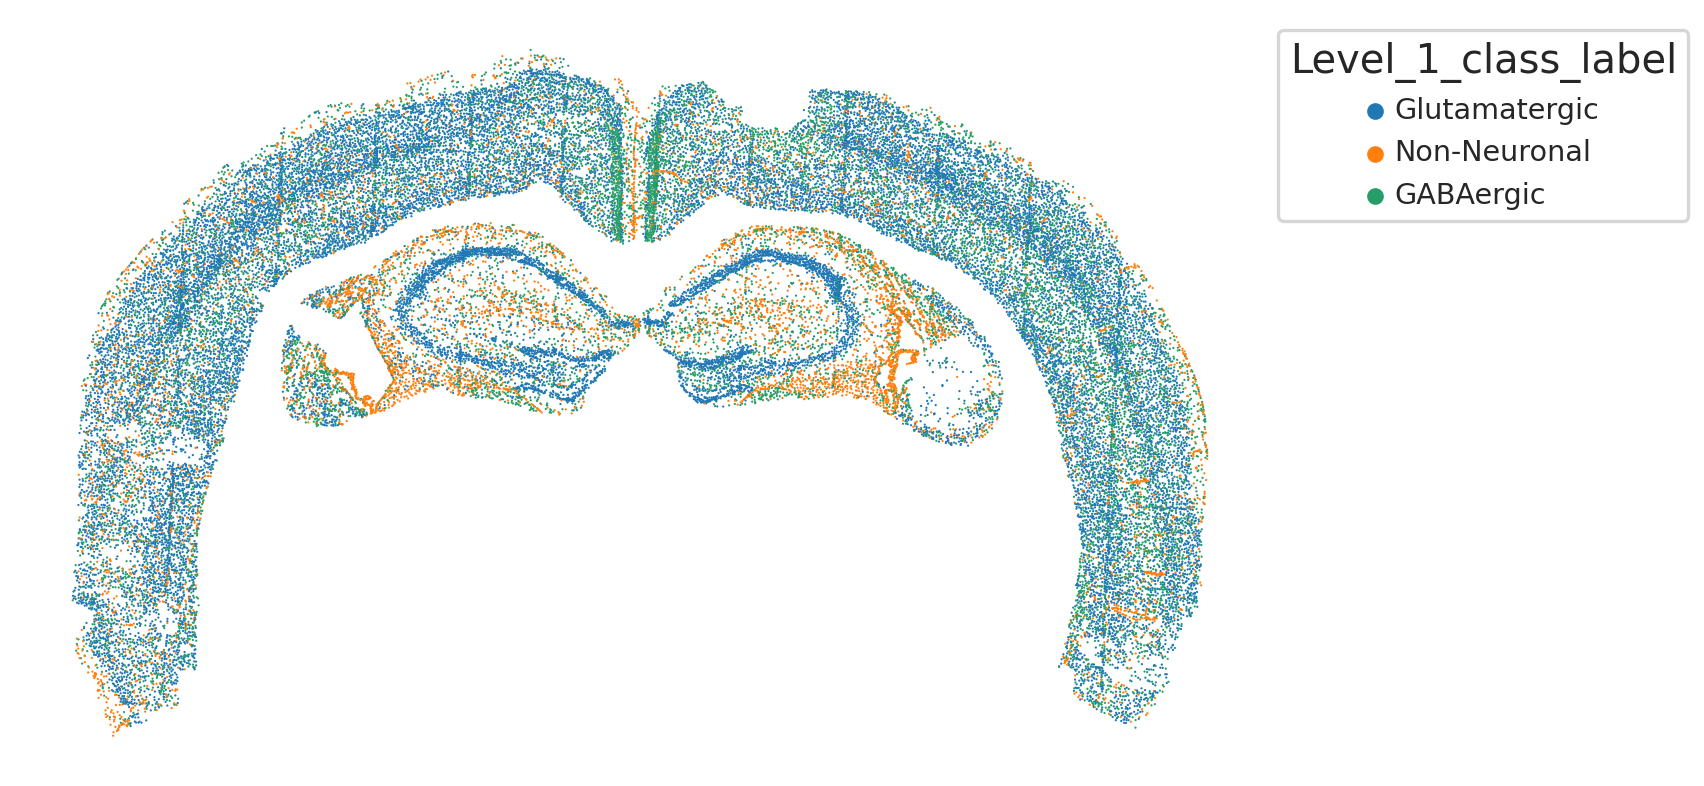

In [ ]:
for level in levels:
    fig, ax = plt.subplots(figsize=(10,8))
    sns.scatterplot(data=res, x='coord_x', y='coord_y', hue=level,
                    # hue_order=np.sort(np.unique(res[level])),
                    s=1,
                    edgecolor='none',
                    rasterized=True,
                   )
    ax.axis('off')
    ax.legend(bbox_to_anchor=(1,1), 
              loc='upper left', 
              # ncol=1+int(len(np.unique(res[level]))/20), 
              title=level,
             )
    ax.invert_yaxis()
    ax.set_aspect('equal')
    plt.show()

In [ ]:
# # input_celltypes = f'{res_dir}noHarmony_March30_v4_isocortex_hpf.csv'
# # print(input_celltypes)
input_embed1 = f'{res_dir}Joint_UMAP_isocortex_hpf_April1.csv'
print(input_embed1)
input_embed2 = f'{res_dir}Joint_UMAP_isocortex_hpf_subsamp100_level1_April1.csv'
print(input_embed2)

# analysis metadata
meta_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/analysis_meta_Mar31.json'


In [ ]:
# analysis
with open(meta_path, 'r') as fh:
    meta = json.load(fh)

In [ ]:
# results
dftypes = res.copy() #pd.read_csv(input_celltypes, index_col=0)
dftypes = dftypes.filter(regex=r'^Level_[0-9]', axis=1)
levels = dftypes.columns.values

# update data
# data.obs = data.obs.join(dftypes)
for level in levels:
    if level in data.obs.columns.values:
        data.obs = data.obs.drop(level, axis=1)
data.obs = data.obs.join(dftypes)

# update the joint one
dfembed1 = pd.read_csv(input_embed1, index_col=0)
dfembed2 = pd.read_csv(input_embed2, index_col=0)
dfembed1 = dfembed1.join(pd.concat([data.obs, ref_data.obs]))
dfembed2 = dfembed2.join(pd.concat([data.obs, ref_data.obs]))

print(dftypes.shape, dfembed1.shape, dfembed2.shape, data.obs.shape)

# Organize information

In [ ]:

# importlib.reload(evalu)
resobj = evalu.Level3Res(meta, levels, 
                ref_data, data, 
                refdata_name='scRNA-seq', data_name='dredFISH',
                embed=True, df_embed=dfembed1,
               )

In [ ]:
levels

In [ ]:

# embed eval
# resobj.plot_embeds(hues=['dataset']+levels[:2].tolist())

# gene eval
resobj.plot_genes()

# spatial eval
resobj.plot_spatial()


In [ ]:
# work on UMAP embedding

In [ ]:
data

In [ ]:
level = 'Level_3_subclass_label'
X_data.shape, X_refdata.shape, res[level].shape, ref_data.obs[level].shape

In [ ]:
level = 'Level_3_subclass_label'
X = resobj.X
Y = resobj.Y
xlabels = resobj.Xobs[level]
ylabels = resobj.Yobs[level]
X.shape, Y.shape, xlabels.shape, ylabels.shape

In [ ]:
Yadj = np.zeros(Y.shape)

clsts = np.sort(xlabels.unique())
for clst in clsts:
    cellx = np.arange(len(xlabels))[xlabels==clst]
    celly = np.arange(len(ylabels))[ylabels==clst]
    
    subX = X[cellx,:].copy()
    subY = Y[celly,:].copy()

    # print(subX.shape, subY.shape)
    
    muX, sigmaX = np.mean(subX, axis=0), np.std(subX, axis=0)
    muY, sigmaY = np.mean(subY, axis=0), np.std(subY, axis=0)
    
    if np.any(sigmaY == 0):
        subY = muX.reshape(1,-1)
    else:
        subY = (subY - muY.reshape(1,-1))*(sigmaX/sigmaY).reshape(1,-1) + muX.reshape(1,-1)
    
    Yadj[celly,:] = subY.copy()
    
Yadj

In [ ]:
def get_umap(Xcell, Ycell, 
             Xidx, Yidx, 
             Xname, Yname,
             **kwargs):
    """
    """
    # run UMAP
    embed = umap.UMAP(**kwargs).fit_transform(
        np.vstack([Xcell, Ycell])
        )

    dfembed = pd.DataFrame(index=np.hstack([Xidx, Yidx])) 
    dfembed['dataset'] = [Xname]*len(Xidx) + [Yname]*len(Yidx) 
    dfembed['embed_1'] = embed[:,0]
    dfembed['embed_2'] = embed[:,1]
    
    return dfembed 

In [ ]:
dfembed = get_umap(
    X, Yadj, 
    resobj.Xobs.index.values, 
    resobj.Yobs.index.values, 
    'scRNA-seq', 'dredFISH',
    verbose=True,
    )

In [ ]:
output = "/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/umap_corrected_features_using_labels.csv"
dfembed.to_csv(output, index=True, header=True)

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=dfembed.sample(frac=1), 
                x='embed_1', y='embed_2', hue='dataset',
                s=1, 
                edgecolor="none",
               )
ax.axis('off')
ax.set_aspect('equal')
ax.set_title('Cell type specific transformation (mean, std)')
plt.show()

In [ ]:
f = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/Joint_UMAP_harmony_correlation_April14.csv'
dfembed2 = pd.read_csv(f, index_col=0)
dfembed2

In [ ]:
dfplot = dfembed2

fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=dfplot.sample(frac=1), 
                x='embed_1', y='embed_2', hue='dataset',
                s=1, 
                edgecolor="none",
               )
ax.axis('off')
ax.set_aspect('equal')
ax.set_title('Harmony')
plt.show()

In [ ]:
# re
dfclst = pd.concat([ref_data.obs, res]).dropna(axis=1)[levels]
dfres1 = dfembed.join(dfclst)
dfres2 = dfembed2.join(dfclst)
dfres2
        

In [ ]:
dfplot = dfres2

fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=dfplot.sample(frac=1), 
                x='embed_1', y='embed_2', hue='dataset',
                s=1, 
                edgecolor="none",
               )
ax.axis('off')
ax.set_aspect('equal')
ax.set_title('Harmony')
plt.show()

In [ ]:
dfplot = dfres1
palette = meta['l3_palette']

fig, axs = plt.subplots(1, 2, figsize=(10*2,10))

datasets = np.sort(dfplot['dataset'].unique())
hue_order = np.sort(dfplot['Level_3_subclass_label'].unique())

for i, (ax, dataset) in enumerate(zip(axs, datasets)):
    dfsub = dfplot[dfplot['dataset']==dataset]
    if i == 0:
        legend = True
    else:
        legend = False
        
    sns.scatterplot(data=dfplot,
                    x='embed_1', y='embed_2',# hue='Level_3_subclass_label',
                    color='lightgray',
                    s=1,
                    ax=ax,
                   )
    sns.scatterplot(data=dfsub.sample(frac=1), 
                    x='embed_1', y='embed_2', hue='Level_3_subclass_label',
                    s=1, 
                    edgecolor="none",
                    legend=legend,
                    hue_order=hue_order,
                    palette=palette,
                    ax=ax,
                   )
    # sns.despine(ax=ax)
    ax.axis('off')
    ax.arrow(0,0, 0, 0.2, fc='k', ec='k', transform=ax.transAxes)
    ax.arrow(0,0, 0.2, 0, fc='k', ec='k', transform=ax.transAxes)
    ax.text(0.01,0.01, "UMAP", transform=ax.transAxes)
    ax.set_aspect('equal')
    ax.set_title(dataset)
    
    if i == 0:
        ax.legend(loc='upper left', bbox_to_anchor=(0,0), ncol=9)
    
fig.subplots_adjust(wspace=0)
fig.suptitle('Coordinates by mean-std matching per cell type; Colored by cell types')
plt.show()

In [ ]:

dfplot = dfres2
palette = meta['l3_palette']

fig, axs = plt.subplots(1, 2, figsize=(10*2,10))

datasets = np.sort(dfplot['dataset'].unique())
hue_order = np.sort(dfplot['Level_3_subclass_label'].unique())

for i, (ax, dataset) in enumerate(zip(axs, datasets)):
    dfsub = dfplot[dfplot['dataset']==dataset]
    if i == 0:
        legend = True
    else:
        legend = False
        
    sns.scatterplot(data=dfplot,
                    x='embed_1', y='embed_2',# hue='Level_3_subclass_label',
                    color='lightgray',
                    s=1,
                    ax=ax,
                   )
    sns.scatterplot(data=dfsub.sample(frac=1), 
                    x='embed_1', y='embed_2', hue='Level_3_subclass_label',
                    s=1, 
                    edgecolor="none",
                    legend=legend,
                    hue_order=hue_order,
                    palette=palette,
                    ax=ax,
                   )
    # sns.despine(ax=ax)
    ax.axis('off')
    ax.arrow(0,0, 0, 0.2, fc='k', ec='k', transform=ax.transAxes)
    ax.arrow(0,0, 0.2, 0, fc='k', ec='k', transform=ax.transAxes)
    ax.text(0.01,0.01, "UMAP", transform=ax.transAxes)
    ax.set_aspect('equal')
    ax.set_title(dataset)
    
    if i == 0:
        ax.legend(loc='upper left', bbox_to_anchor=(0,0), ncol=9)
    
fig.subplots_adjust(wspace=0)
fig.suptitle('Coordinates by Harmony; Colored by cell types')
plt.show()